In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
#@title
!pip install -q gputil psutil humanize

import psutil
import humanize
import os
import GPUtil as GPU

GPUs = GPU.getGPUs()

In [ ]:
#@title
# Imports

import tensorflow as tf
import numpy as np

import tensorflow as tf
from tensorflow.keras.activations import softmax
from typing import Callable, Union

from tensorflow.keras import Model
from tensorflow.keras.layers import Input, concatenate, Conv2D, MaxPooling2D, UpSampling2D, SpatialDropout2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import backend as K

import time
import os
from skimage.io import imsave, imshow
import numpy as np
import tensorflow as tf

from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Input, concatenate, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
import pandas as pd
import matplotlib.pyplot as plt
from skimage.transform import resize
#from skimage.util import crop
from skimage.io import imsave, imread
from keras.utils import  Sequence

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose, BatchNormalization, Activation, Dropout, Reshape, Permute
from tensorflow.keras.optimizers import Adadelta, Nadam
from tensorflow.keras.losses import binary_crossentropy

In [ ]:
#@title
gpu = GPUs[0]

def printm():
  process = psutil.Process(os.getpid())
  print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))

printm()

Gen RAM Free: 12.7 GB  | Proc size: 375.1 MB
GPU RAM Free: 15079MB | Used: 0MB | Util   0% | Total 15079MB


In [ ]:
#@title
# Util functions

def threshold(a):
    a[a<0.5]=0
    a[a>0.5]=1
    return a

def stack_masks(m0, m1, m2, m3):
    mask = m0
    mask = np.append(mask, m1, axis = 3)
    mask = np.append(mask, m2, axis = 3)
    mask = np.append(mask, m3, axis = 3)
    return mask

def stack_masks3(m0, m1, m2):
    mask = m0
    mask = np.append(mask, m1, axis = 3)
    mask = np.append(mask, m2, axis = 3)
    return mask

def test_model(model, x, y_true, log_dir):
    y_true = np.rint(y_true[0])
    y_pred = model.predict(x)
    y_pred = np.rint(y_pred[0])
    x = x[0]

    plt.figure(figsize=(40,8))
    plt.subplot(1, 3, 1)
    plt.title('Input')
    plt.imshow(np.squeeze(x))

    plt.subplot(1, 3, 2)
    plt.title('Prediction')
    plt.imshow(np.squeeze(y_pred))

    plt.subplot(1, 3, 3)
    plt.title('Ground truth')
    plt.imshow(np.squeeze(y_true))

    plt.savefig(os.path.join(log_dir,'ground_truth_e{}.pdf'.format('test')), bbox_inches='tight', dpi=300)
    plt.show()

def test_model_nobg(model, x, y_true, log_dir):
    y_true = np.rint(y_true[0])
    y_pred = model.predict(x)
    y_pred = stack_masks3(y_pred[0],y_pred[1],y_pred[2])
    y_pred = np.rint(y_pred[0])
    x = x[0]

    plt.figure(figsize=(40,8))
    plt.subplot(1, 3, 1)
    plt.title('Input')
    plt.imshow(np.squeeze(x))
    plt.subplot(1, 3, 2)
    plt.title('Prediction')
    plt.imshow(np.squeeze(y_pred[:,:,:]))
    plt.subplot(1, 3, 3)
    plt.title('Ground truth')
    plt.imshow(np.squeeze(y_true[:,:,:]))
    plt.savefig(os.path.join(log_dir,'ground_truth_e{}.pdf'.format('test')), bbox_inches='tight', dpi=300)
    plt.show()


def test_model_bg(model, x, y_true, log_dir):
    y_true = np.rint(y_true[0])
    y_pred = model.predict(x)
    y_pred = stack_masks(y_pred[0],y_pred[1],y_pred[2],y_pred[3])
    y_pred = np.rint(y_pred[0])
    x = x[0]

    plt.figure(figsize=(40,8))
    plt.subplot(1, 5, 1)
    plt.title('Input')
    plt.imshow(np.squeeze(x))
    plt.subplot(1, 5, 2)
    plt.title('Prediction - bg')
    plt.imshow(np.squeeze(y_pred[:,:,0]))
    plt.subplot(1, 5, 3)
    plt.title('Prediction - fg')
    plt.imshow(np.squeeze(y_pred[:,:,1:4]))
    plt.subplot(1, 5, 4)
    plt.title('Ground truth - bg')
    plt.imshow(np.squeeze(y_true[:,:,0]))
    plt.subplot(1, 5, 5)
    plt.title('Ground truth - fg')
    plt.imshow(np.squeeze(y_true[:,:,1:4]))
    plt.savefig(os.path.join(log_dir,'ground_truth_e{}.pdf'.format('test')), bbox_inches='tight', dpi=300)
    plt.show()


def checkDir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

def combine_generators(gen_img, gen1, gen2, gen3, gen4):
    while True:
        yield(gen_img.next(), (gen1.next(), gen2.next(), gen3.next(), gen4.next()))

def combine_generators3(gen_img, gen1, gen2, gen3):
    while True:
        yield(gen_img.next(), (gen1.next(), gen2.next(), gen3.next()))

def dice_coeff(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

def jaccard_distance(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    return (intersection + smooth) / (sum_ - intersection + smooth)
    
def conv_block(tensor, nfilters, size=3, padding='same', initializer="he_normal"):
    x = Conv2D(filters=nfilters, kernel_size=(size, size), padding=padding, kernel_initializer=initializer)(tensor)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(filters=nfilters, kernel_size=(size, size), padding=padding, kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x


def deconv_block(tensor, residual, nfilters, size=3, padding='same', strides=(2, 2)):
    y = Conv2DTranspose(nfilters, kernel_size=(size, size), strides=strides, padding=padding)(tensor)
    y = concatenate([y, residual], axis=3)
    y = conv_block(y, nfilters)
    return y



def Unet(img_height, img_width, nclasses=4, filters=8, do=0.2):
# down
    input_layer = Input(shape=(img_height, img_width, 1), name='image_input')
    conv1 = conv_block(input_layer, nfilters=filters)
    conv1_out = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv1_out = SpatialDropout2D(do)(conv1_out)
    conv2 = conv_block(conv1_out, nfilters=filters*2)
    conv2_out = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv2_out = SpatialDropout2D(do)(conv2_out)
    conv3 = conv_block(conv2_out, nfilters=filters*4)
    conv3_out = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv3_out = SpatialDropout2D(do)(conv3_out)
    conv4 = conv_block(conv3_out, nfilters=filters*8)
    conv4_out = MaxPooling2D(pool_size=(2, 2))(conv4)
    conv4_out = SpatialDropout2D(do)(conv4_out)
    conv5 = conv_block(conv4_out, nfilters=filters*16)
    conv5 = SpatialDropout2D(do)(conv5)
# up
    deconv6 = deconv_block(conv5, residual=conv4, nfilters=filters*8)
    deconv6 = SpatialDropout2D(do)(deconv6)
    deconv7 = deconv_block(deconv6, residual=conv3, nfilters=filters*4)
    deconv7 = SpatialDropout2D(do)(deconv7) 
    deconv8 = deconv_block(deconv7, residual=conv2, nfilters=filters*2)
    deconv8 = SpatialDropout2D(do)(deconv8)
    deconv9 = deconv_block(deconv8, residual=conv1, nfilters=filters)
# output
    output_layer = Conv2D(filters=nclasses, kernel_size=(1, 1))(deconv9)
    output_layer = BatchNormalization()(output_layer)
    #output_layer = Reshape((img_height*img_width, nclasses), input_shape=(img_height, img_width, nclasses))(output_layer)
    output_layer = Activation('sigmoid')(output_layer)
    
    model = Model(inputs=input_layer, outputs=output_layer, name='Unet')
    return model

def Unet_multihead_3head(img_height, img_width, nclasses=1, filters=8, do=0.2, do_diff=[0.2, 0.2, 0.2, 0.2]):
# down
    input_layer = Input(shape=(img_height, img_width, 1), name='image_input')
    conv1 = conv_block(input_layer, nfilters=filters)
    conv1_out = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv1_out = SpatialDropout2D(do)(conv1_out)
    conv2 = conv_block(conv1_out, nfilters=filters*2)
    conv2_out = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv2_out = SpatialDropout2D(do)(conv2_out)
    conv3 = conv_block(conv2_out, nfilters=filters*4)
    conv3_out = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv3_out = SpatialDropout2D(do)(conv3_out)
    conv4 = conv_block(conv3_out, nfilters=filters*8)
    conv4_out = MaxPooling2D(pool_size=(2, 2))(conv4)
    conv4_out = SpatialDropout2D(do)(conv4_out)
    conv5 = conv_block(conv4_out, nfilters=filters*16)
    conv5 = SpatialDropout2D(do)(conv5)


# up
    deconv6_1 = deconv_block(conv5, residual=conv4, nfilters=filters*8)
    deconv6_1 = SpatialDropout2D(do_diff[1])(deconv6_1)
    deconv7_1 = deconv_block(deconv6_1, residual=conv3, nfilters=filters*4)
    deconv7_1 = SpatialDropout2D(do_diff[1])(deconv7_1) 
    deconv8_1 = deconv_block(deconv7_1, residual=conv2, nfilters=filters*2)
    deconv8_1 = SpatialDropout2D(do_diff[1])(deconv8_1)
    deconv9_1 = deconv_block(deconv8_1, residual=conv1, nfilters=filters)
# output
    output_layer_1 = Conv2D(filters=nclasses, kernel_size=(1, 1))(deconv9_1)
    output_layer_1 = BatchNormalization()(output_layer_1)
    #output_layer = Reshape((img_height*img_width, nclasses), input_shape=(img_height, img_width, nclasses))(output_layer)
    output_layer_1 = Activation('sigmoid')(output_layer_1)    

# up
    deconv6_2 = deconv_block(conv5, residual=conv4, nfilters=filters*8)
    deconv6_2 = SpatialDropout2D(do_diff[2])(deconv6_2)
    deconv7_2 = deconv_block(deconv6_2, residual=conv3, nfilters=filters*4)
    deconv7_2 = SpatialDropout2D(do_diff[2])(deconv7_2) 
    deconv8_2 = deconv_block(deconv7_2, residual=conv2, nfilters=filters*2)
    deconv8_2 = SpatialDropout2D(do_diff[2])(deconv8_2)
    deconv9_2 = deconv_block(deconv8_2, residual=conv1, nfilters=filters)
# output
    output_layer_2 = Conv2D(filters=nclasses, kernel_size=(1, 1))(deconv9_2)
    output_layer_2 = BatchNormalization()(output_layer_2)
    #output_layer = Reshape((img_height*img_width, nclasses), input_shape=(img_height, img_width, nclasses))(output_layer)
    output_layer_2 = Activation('sigmoid')(output_layer_2)

# up
    deconv6_3 = deconv_block(conv5, residual=conv4, nfilters=filters*8)
    deconv6_3 = SpatialDropout2D(do_diff[3])(deconv6_3)
    deconv7_3 = deconv_block(deconv6_3, residual=conv3, nfilters=filters*4)
    deconv7_3 = SpatialDropout2D(do_diff[3])(deconv7_3) 
    deconv8_3 = deconv_block(deconv7_3, residual=conv2, nfilters=filters*2)
    deconv8_3 = SpatialDropout2D(do_diff[3])(deconv8_3)
    deconv9_3 = deconv_block(deconv8_3, residual=conv1, nfilters=filters)
# output
    output_layer_3 = Conv2D(filters=nclasses, kernel_size=(1, 1))(deconv9_3)
    output_layer_3 = BatchNormalization()(output_layer_3)
    #output_layer = Reshape((img_height*img_width, nclasses), input_shape=(img_height, img_width, nclasses))(output_layer)
    output_layer_3 = Activation('sigmoid')(output_layer_3)


    model = Model(inputs=input_layer, outputs=[output_layer_1,output_layer_2,output_layer_3], name='Unet_multihead_3head')
    return model

def Unet_multihead(img_height, img_width, nclasses=1, filters=8, do=0.2, do_diff=[0.2, 0.2, 0.2]):
# down
    input_layer = Input(shape=(img_height, img_width, 1), name='image_input')
    conv1 = conv_block(input_layer, nfilters=filters)
    conv1_out = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv1_out = SpatialDropout2D(do)(conv1_out)
    conv2 = conv_block(conv1_out, nfilters=filters*2)
    conv2_out = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv2_out = SpatialDropout2D(do)(conv2_out)
    conv3 = conv_block(conv2_out, nfilters=filters*4)
    conv3_out = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv3_out = SpatialDropout2D(do)(conv3_out)
    conv4 = conv_block(conv3_out, nfilters=filters*8)
    conv4_out = MaxPooling2D(pool_size=(2, 2))(conv4)
    conv4_out = SpatialDropout2D(do)(conv4_out)
    conv5 = conv_block(conv4_out, nfilters=filters*16)
    conv5 = SpatialDropout2D(do)(conv5)
# up
    deconv6_0 = deconv_block(conv5, residual=conv4, nfilters=filters*8)
    deconv6_0 = SpatialDropout2D(do_diff[0])(deconv6_0)
    deconv7_0 = deconv_block(deconv6_0, residual=conv3, nfilters=filters*4)
    deconv7_0 = SpatialDropout2D(do_diff[0])(deconv7_0) 
    deconv8_0 = deconv_block(deconv7_0, residual=conv2, nfilters=filters*2)
    deconv8_0 = SpatialDropout2D(do_diff[0])(deconv8_0)
    deconv9_0 = deconv_block(deconv8_0, residual=conv1, nfilters=filters)
# output
    output_layer_0 = Conv2D(filters=nclasses, kernel_size=(1, 1))(deconv9_0)
    output_layer_0 = BatchNormalization()(output_layer_0)
    #output_layer = Reshape((img_height*img_width, nclasses), input_shape=(img_height, img_width, nclasses))(output_layer)
    output_layer_0 = Activation('sigmoid')(output_layer_0)

# up
    deconv6_1 = deconv_block(conv5, residual=conv4, nfilters=filters*8)
    deconv6_1 = SpatialDropout2D(do_diff[1])(deconv6_1)
    deconv7_1 = deconv_block(deconv6_1, residual=conv3, nfilters=filters*4)
    deconv7_1 = SpatialDropout2D(do_diff[1])(deconv7_1) 
    deconv8_1 = deconv_block(deconv7_1, residual=conv2, nfilters=filters*2)
    deconv8_1 = SpatialDropout2D(do_diff[1])(deconv8_1)
    deconv9_1 = deconv_block(deconv8_1, residual=conv1, nfilters=filters)
# output
    output_layer_1 = Conv2D(filters=nclasses, kernel_size=(1, 1))(deconv9_1)
    output_layer_1 = BatchNormalization()(output_layer_1)
    #output_layer = Reshape((img_height*img_width, nclasses), input_shape=(img_height, img_width, nclasses))(output_layer)
    output_layer_1 = Activation('sigmoid')(output_layer_1)    

# up
    deconv6_2 = deconv_block(conv5, residual=conv4, nfilters=filters*8)
    deconv6_2 = SpatialDropout2D(do_diff[2])(deconv6_2)
    deconv7_2 = deconv_block(deconv6_2, residual=conv3, nfilters=filters*4)
    deconv7_2 = SpatialDropout2D(do_diff[2])(deconv7_2) 
    deconv8_2 = deconv_block(deconv7_2, residual=conv2, nfilters=filters*2)
    deconv8_2 = SpatialDropout2D(do_diff[2])(deconv8_2)
    deconv9_2 = deconv_block(deconv8_2, residual=conv1, nfilters=filters)
# output
    output_layer_2 = Conv2D(filters=nclasses, kernel_size=(1, 1))(deconv9_2)
    output_layer_2 = BatchNormalization()(output_layer_2)
    #output_layer = Reshape((img_height*img_width, nclasses), input_shape=(img_height, img_width, nclasses))(output_layer)
    output_layer_2 = Activation('sigmoid')(output_layer_2)

# up
    deconv6_3 = deconv_block(conv5, residual=conv4, nfilters=filters*8)
    deconv6_3 = SpatialDropout2D(do_diff[3])(deconv6_3)
    deconv7_3 = deconv_block(deconv6_3, residual=conv3, nfilters=filters*4)
    deconv7_3 = SpatialDropout2D(do_diff[3])(deconv7_3) 
    deconv8_3 = deconv_block(deconv7_3, residual=conv2, nfilters=filters*2)
    deconv8_3 = SpatialDropout2D(do_diff[3])(deconv8_3)
    deconv9_3 = deconv_block(deconv8_3, residual=conv1, nfilters=filters)
# output
    output_layer_3 = Conv2D(filters=nclasses, kernel_size=(1, 1))(deconv9_3)
    output_layer_3 = BatchNormalization()(output_layer_3)
    #output_layer = Reshape((img_height*img_width, nclasses), input_shape=(img_height, img_width, nclasses))(output_layer)
    output_layer_3 = Activation('sigmoid')(output_layer_3)


    model = Model(inputs=input_layer, outputs=[output_layer_0,output_layer_1,output_layer_2,output_layer_3], name='Unet_multihead')
    return model


In [ ]:
#@title
# TF dimension ordering in this code
K.set_image_data_format('channels_last')  
# Shared parameters

mask_cls=3 #4
img_cols = 900
img_rows = 900
batch_size = 80 #4800
smooth = 1.

target_width = 96 #128
target_height = 96 #128

start_lr = 1e-4
epochs = 300 #200

seed = 123

# Generators settings

img_gen_args = dict(samplewise_center=True,
                     samplewise_std_normalization=True,
                     rotation_range=30,
                     width_shift_range=0.15,
                     height_shift_range=0.15,
                     vertical_flip=True,
                     horizontal_flip=True,
                     zoom_range=[0.8,1.2],
                     #brightness_range=[0.8,1.2],
                     fill_mode='nearest')

mask_gen_args = dict(samplewise_center=False,
                     samplewise_std_normalization=False,
                     rotation_range=15,
                     width_shift_range=0.15,
                     height_shift_range=0.15,
                     vertical_flip=True,
                     horizontal_flip=True,
                     preprocessing_function=np.rint,
                     zoom_range=[0.8,1.2],
                     fill_mode='nearest')

image_datagen = ImageDataGenerator(**img_gen_args)
mask_datagen = ImageDataGenerator(**mask_gen_args)

test_image_datagen = ImageDataGenerator(samplewise_center=True,
                                        samplewise_std_normalization=True,
                                        rotation_range=0,
                                        width_shift_range=0.0,
                                        height_shift_range=0.0,
                                        brightness_range=None,
                                        shear_range=0.0,
                                        zoom_range=0.0)

test_mask_datagen = ImageDataGenerator(samplewise_center=False,
                                       samplewise_std_normalization=False,
                                       rotation_range=0,
                                       width_shift_range=0.0,
                                       height_shift_range=0.0,
                                       brightness_range=None,
                                       shear_range=0.0,
                                       preprocessing_function=np.rint,
                                       zoom_range=0.0)


# Unet Binarry Classification (Full Worm) Foreground

Here the masks dimension is stored as background. Hence to get the foregranound we return it as 1 - mask



Model: "Unet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        [(None, 96, 96, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 96, 96, 8)    80          image_input[0][0]                
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 96, 96, 8)    32          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 96, 96, 8)    0           batch_normalization[0][0]        
_______________________________________________________________________________________________

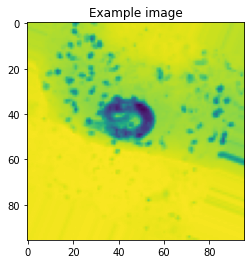

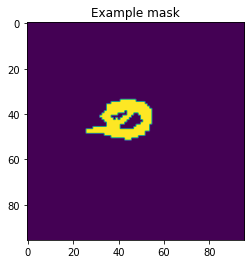

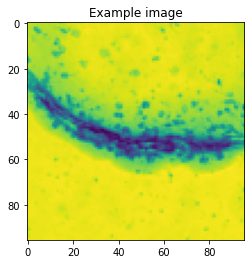

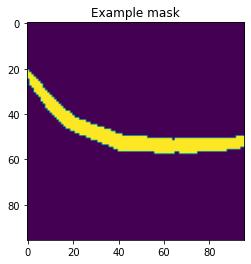

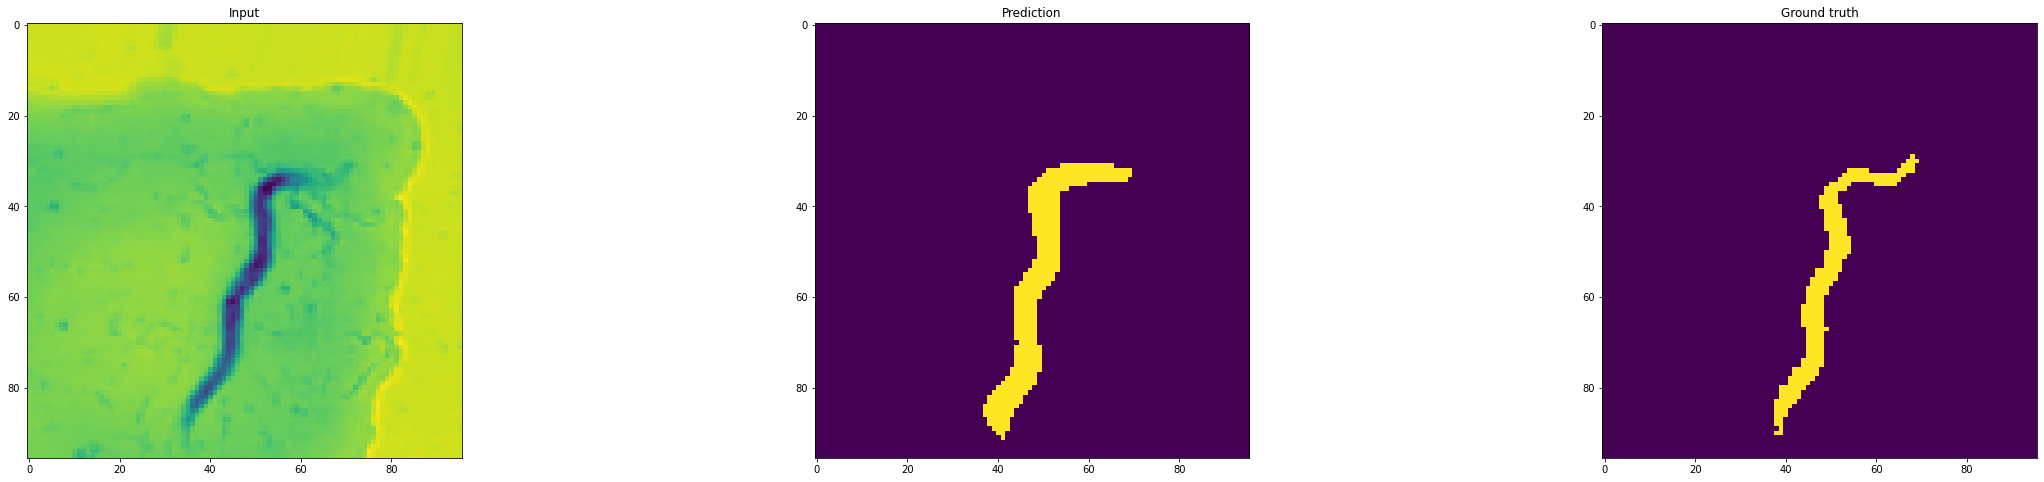

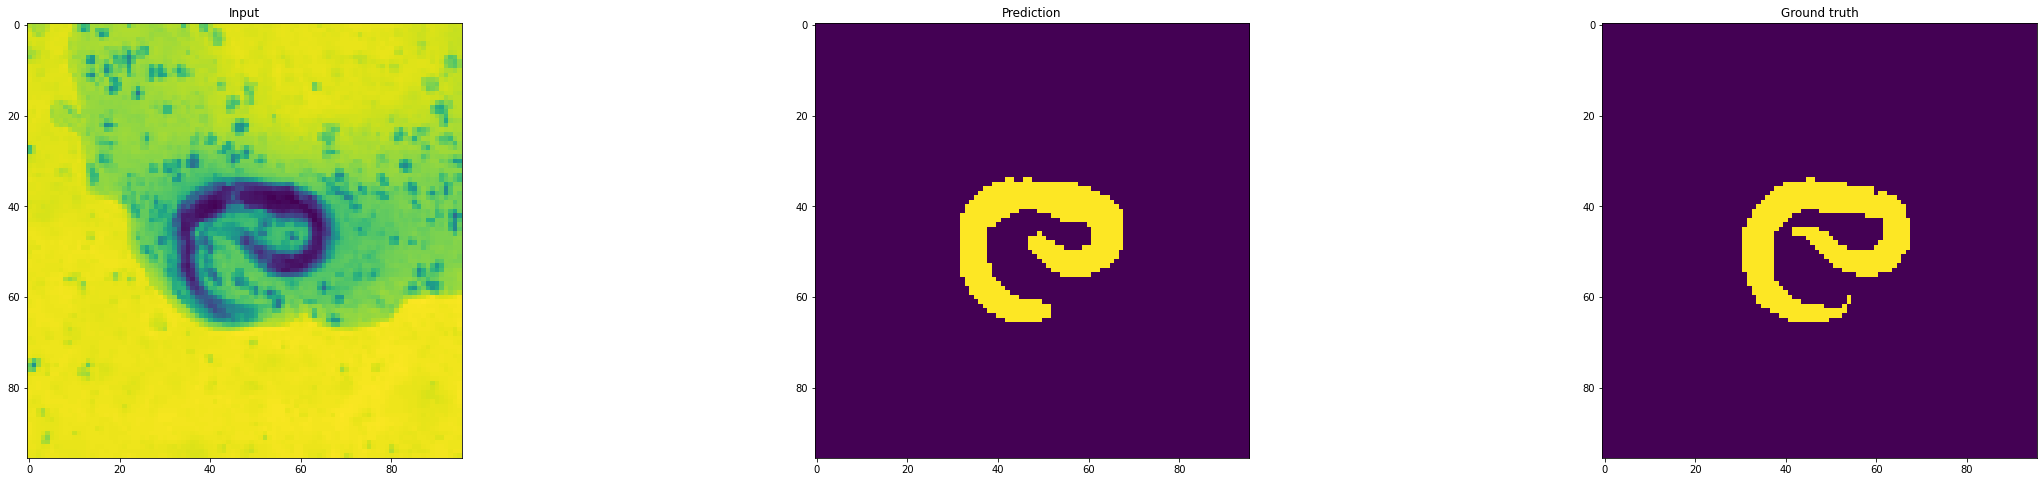

In [ ]:
upscale_factor_width = img_cols / target_width
upscale_factor_height = img_cols / target_height

runningTime = time.strftime('%b-%d-%Y_%H-%M')
model_dir = '/content/drive/My Drive/worm_models/fine-segmentation/models/final'

log_dir = os.path.join(model_dir,"{}_unet_full_worm_fg".format(runningTime))
checkDir(log_dir)

training_img_dir = os.path.join(model_dir,'..','..','train','img')
test_img_dir = os.path.join(model_dir,'..','..','test','img')

# load training images and masks
training_imgs = np.load(os.path.join(model_dir,'..','..','train','train_imgs_{}.npy'.format(target_height)))
training_masks = np.load(os.path.join(model_dir,'..','..','train','train_msks_{}.npy'.format(target_height)))
training_masks = np.rint((1 - training_masks)[:,:,:,0][..., np.newaxis])


# load test images and masks
test_imgs = np.load(os.path.join(model_dir,'..','..','test','test_imgs_{}.npy'.format(target_height)))
test_masks = np.load(os.path.join(model_dir,'..','..','test','test_msks_{}.npy'.format(target_height)))
test_masks = np.rint((1 - test_masks[:,:,:,0])[..., np.newaxis])


image_datagen.fit(training_imgs, augment=True, seed=seed)
mask_datagen.fit(training_masks, augment=True, seed=seed)

test_image_datagen.fit(test_imgs, augment=False, seed=seed)
test_mask_datagen.fit(test_masks, augment=False, seed=seed)

image_generator = image_datagen.flow(training_imgs, batch_size=batch_size, seed=seed)
mask_generator = mask_datagen.flow(training_masks, batch_size=batch_size, seed=seed)


test_image_generator = test_image_datagen.flow(test_imgs, batch_size=batch_size, seed=seed)
test_mask_generator = test_mask_datagen.flow(test_masks, batch_size=batch_size, seed=seed)


img_exmp = image_generator.next()
mask_exmp = mask_generator.next()

plt.figure()
plt.title('Example image')
plt.imshow(np.squeeze(img_exmp[0]))

plt.figure()
plt.title('Example mask')
plt.imshow(np.squeeze(mask_exmp[0,:,:,0]))

test_img_exmp = test_image_generator.next()
test_mask_exmp = test_mask_generator.next()

plt.figure()
plt.title('Example image')
plt.imshow(np.squeeze(test_img_exmp[0]))


plt.figure()
plt.title('Example mask')
plt.imshow(np.squeeze(test_mask_exmp[0,:,:,0]))

gen_train = zip(image_generator, mask_generator)
gen_test = zip(test_image_generator, test_mask_generator)



tensorboard = TensorBoard(log_dir=log_dir)
callbacksList = [tensorboard]

model = Unet(target_width, target_height, nclasses=1)
model.compile(optimizer=Adam(lr=start_lr), loss=dice_loss, metrics=[dice_coeff, jaccard_distance, 'accuracy'])
#model.compile(SGD(lr=start_lr, momentum=0.9, decay=0.01), loss=binary_crossentropy, metrics=[dice_coeff, jaccard_distance, 'accuracy'])
model.summary()
print("start tesorboard, cmd: tensorboard --logdir=\""+os.path.join(log_dir,"{}".format(runningTime)+"\""))

model.fit(
        gen_train,
        steps_per_epoch=100, #200, 40
        epochs=epochs,
        validation_freq = 1,
        validation_data=gen_test, validation_steps=1,
        callbacks=callbacksList)

img_exmp = image_generator.next()
mask_exmp = mask_generator.next()


test_model(model, img_exmp, mask_exmp, log_dir)
test_img_exmp = test_image_generator.next()
test_mask_exmp = test_mask_generator.next()

test_model(model, test_img_exmp, test_mask_exmp, log_dir)
model.save(os.path.join(log_dir,'model.h5'))

# Unet Multiclass Classification Foreground

Here the masks dimension is stored as background. Hence to get the foregranound we return it as 1 - mask



Model: "Unet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        [(None, 96, 96, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 96, 96, 8)    80          image_input[0][0]                
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 96, 96, 8)    32          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 96, 96, 8)    0           batch_normalization[0][0]        
_______________________________________________________________________________________________

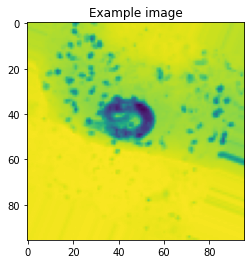

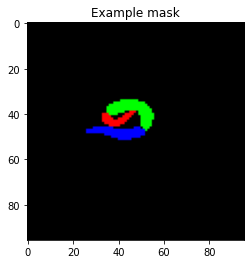

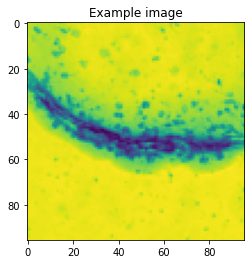

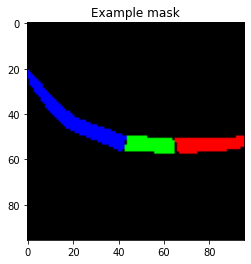

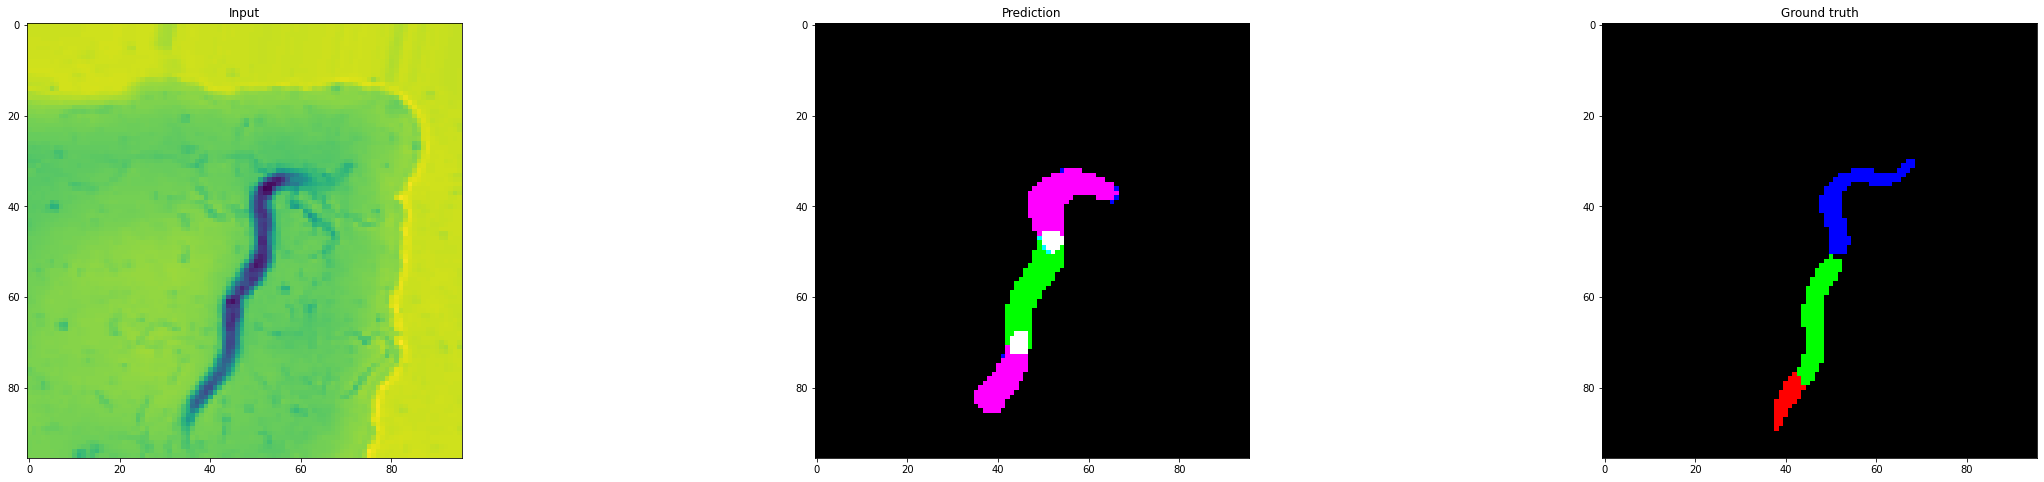

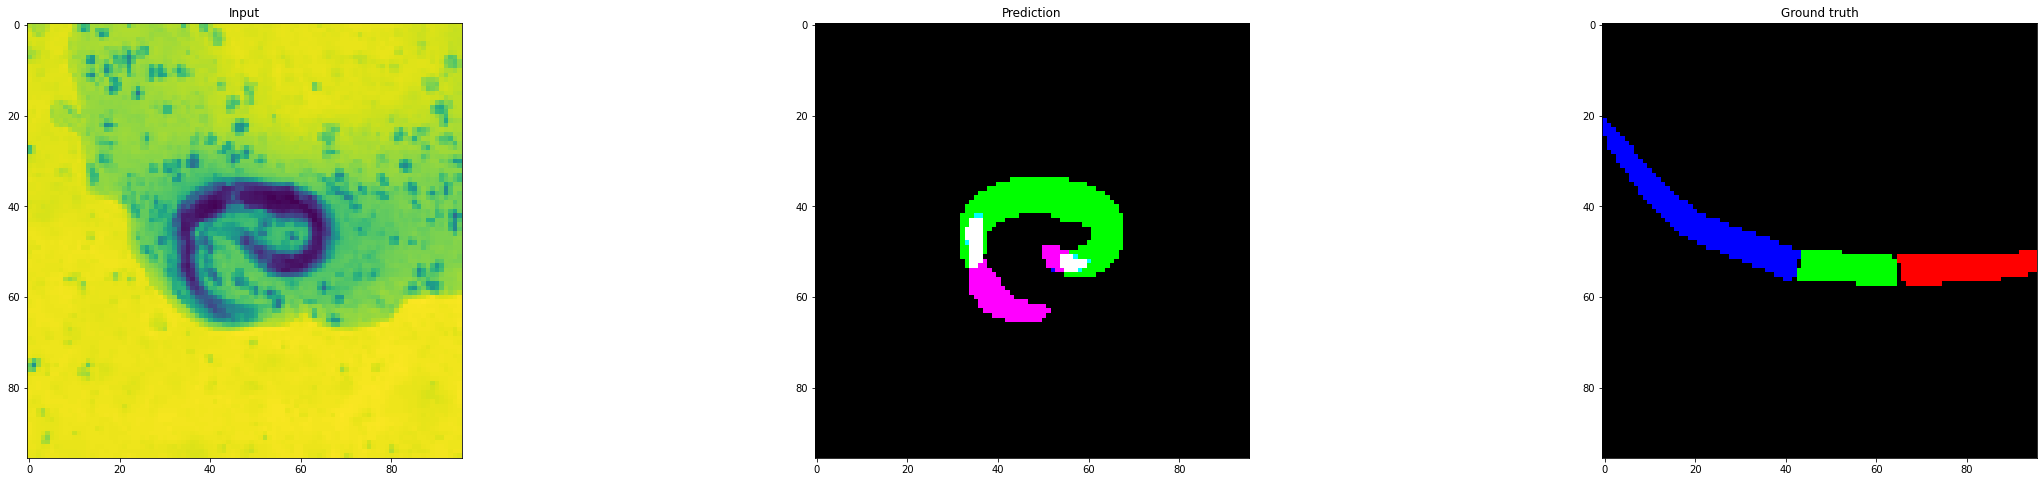

In [ ]:
#@title
upscale_factor_width = img_cols / target_width
upscale_factor_height = img_cols / target_height

runningTime = time.strftime('%b-%d-%Y_%H-%M')
model_dir = '/content/drive/My Drive/worm_models/fine-segmentation/models/final'

log_dir = os.path.join(model_dir,"{}_unet_multiclass_worm_fg".format(runningTime))
checkDir(log_dir)

training_img_dir = os.path.join(model_dir,'..','..','train','img')
test_img_dir = os.path.join(model_dir,'..','..','test','img')

# load training images and masks
training_imgs = np.load(os.path.join(model_dir,'..','..','train','train_imgs_{}.npy'.format(target_height)))
training_masks = np.load(os.path.join(model_dir,'..','..','train','train_msks_{}.npy'.format(target_height)))
training_masks = training_masks[:,:,:,1:4]#[..., np.newaxis]


# load test images and masks
test_imgs = np.load(os.path.join(model_dir,'..','..','test','test_imgs_{}.npy'.format(target_height)))
test_masks = np.load(os.path.join(model_dir,'..','..','test','test_msks_{}.npy'.format(target_height)))
test_masks = test_masks[:,:,:,1:4]#[..., np.newaxis]


image_datagen.fit(training_imgs, augment=True, seed=seed)
mask_datagen.fit(training_masks, augment=True, seed=seed)

test_image_datagen.fit(test_imgs, augment=False, seed=seed)
test_mask_datagen.fit(test_masks, augment=False, seed=seed)

image_generator = image_datagen.flow(training_imgs, batch_size=batch_size, seed=seed)
mask_generator = mask_datagen.flow(training_masks, batch_size=batch_size, seed=seed)


test_image_generator = test_image_datagen.flow(test_imgs, batch_size=batch_size, seed=seed)
test_mask_generator = test_mask_datagen.flow(test_masks, batch_size=batch_size, seed=seed)

gen_train = zip(image_generator, mask_generator)
gen_test = zip(test_image_generator, test_mask_generator)


img_exmp = image_generator.next()
mask_exmp = mask_generator.next()

plt.figure()
plt.title('Example image')
plt.imshow(np.squeeze(img_exmp[0]))

plt.figure()
plt.title('Example mask')
plt.imshow(np.squeeze(mask_exmp[0,:,:,:]))

test_img_exmp = test_image_generator.next()
test_mask_exmp = test_mask_generator.next()

plt.figure()
plt.title('Example image')
plt.imshow(np.squeeze(test_img_exmp[0]))

test_imgs = test_imgs.astype('float32')
plt.figure()
plt.title('Example mask')
plt.imshow(np.squeeze(test_mask_exmp[0,:,:,:]))

test_masks = test_masks.astype('float32')
test_masks = np.rint(test_masks)



tensorboard = TensorBoard(log_dir=log_dir)
callbacksList = [tensorboard]

model = Unet(target_width, target_height, nclasses=3)
model.compile(optimizer=Adam(lr=start_lr), loss=dice_loss, metrics=[dice_coeff, jaccard_distance, 'accuracy'])
model.summary()
print("start tesorboard, cmd: tensorboard --logdir=\""+os.path.join(log_dir,"{}".format(runningTime)+"\""))

model.fit(
        gen_train,
        steps_per_epoch=100, #200, 40
        epochs=epochs,
        validation_freq = 1,
        validation_data=gen_test, validation_steps=1,
        callbacks=callbacksList)

img_exmp = image_generator.next()
mask_exmp = mask_generator.next()


test_model(model, img_exmp, mask_exmp, log_dir)
test_img_exmp = test_image_generator.next()

test_model(model, test_img_exmp, test_mask_exmp, log_dir)
model.save(os.path.join(log_dir,'model.h5'))

# Unet Binarry Classification (Full Worm) Background

Here the masks dimension is stored as background. Hence to get the foregranound we return it as mask

Model: "Unet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        [(None, 96, 96, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 96, 96, 8)    80          image_input[0][0]                
__________________________________________________________________________________________________
batch_normalization_19 (BatchNo (None, 96, 96, 8)    32          conv2d_19[0][0]                  
__________________________________________________________________________________________________
activation_19 (Activation)      (None, 96, 96, 8)    0           batch_normalization_19[0][0]     
_______________________________________________________________________________________________

KeyboardInterrupt: ignored

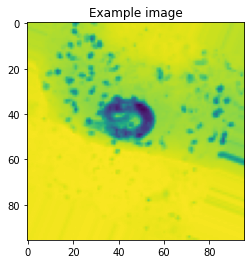

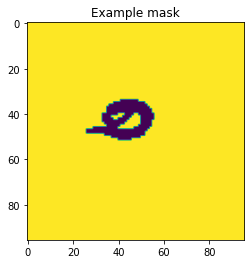

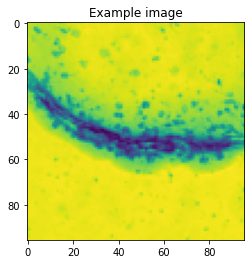

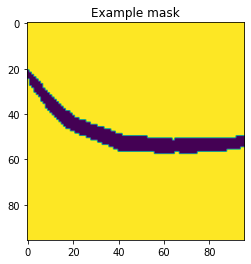

In [ ]:
upscale_factor_width = img_cols / target_width
upscale_factor_height = img_cols / target_height

runningTime = time.strftime('%b-%d-%Y_%H-%M')
model_dir = '/content/drive/My Drive/worm_models/fine-segmentation/models/final'

log_dir = os.path.join(model_dir,"{}_unet_full_worm_bg".format(runningTime))
checkDir(log_dir)

training_img_dir = os.path.join(model_dir,'..','..','train','img')
test_img_dir = os.path.join(model_dir,'..','..','test','img')

# load training images and masks
training_imgs = np.load(os.path.join(model_dir,'..','..','train','train_imgs_{}.npy'.format(target_height)))
training_masks = np.load(os.path.join(model_dir,'..','..','train','train_msks_{}.npy'.format(target_height)))
training_masks = training_masks[:,:,:,0][..., np.newaxis]


# load test images and masks
test_imgs = np.load(os.path.join(model_dir,'..','..','test','test_imgs_{}.npy'.format(target_height)))
test_masks = np.load(os.path.join(model_dir,'..','..','test','test_msks_{}.npy'.format(target_height)))
test_masks = test_masks[:,:,:,0][..., np.newaxis]


image_datagen.fit(training_imgs, augment=True, seed=seed)
mask_datagen.fit(training_masks, augment=True, seed=seed)

test_image_datagen.fit(test_imgs, augment=False, seed=seed)
test_mask_datagen.fit(test_masks, augment=False, seed=seed)

image_generator = image_datagen.flow(training_imgs, batch_size=batch_size, seed=seed)
mask_generator = mask_datagen.flow(training_masks, batch_size=batch_size, seed=seed)


test_image_generator = test_image_datagen.flow(test_imgs, batch_size=batch_size, seed=seed)
test_mask_generator = test_mask_datagen.flow(test_masks, batch_size=batch_size, seed=seed)

gen_train = zip(image_generator, mask_generator)
gen_test = zip(test_image_generator, test_mask_generator)


img_exmp = image_generator.next()
mask_exmp = mask_generator.next()

plt.figure()
plt.title('Example image')
plt.imshow(np.squeeze(img_exmp[0]))

plt.figure()
plt.title('Example mask')
plt.imshow(np.squeeze(mask_exmp[0,:,:,0]))

test_img_exmp = test_image_generator.next()
test_mask_exmp = test_mask_generator.next()

plt.figure()
plt.title('Example image')
plt.imshow(np.squeeze(test_img_exmp[0]))

test_imgs = test_imgs.astype('float32')
plt.figure()
plt.title('Example mask')
plt.imshow(np.squeeze(test_mask_exmp[0,:,:,0]))

test_masks = test_masks.astype('float32')
test_masks = np.rint(test_masks)



tensorboard = TensorBoard(log_dir=log_dir)
callbacksList = [tensorboard]

model = Unet(target_width, target_height, nclasses=1)
model.compile(optimizer=Adam(lr=start_lr), loss=dice_loss, metrics=[dice_coeff, jaccard_distance, 'accuracy'])
model.summary()
print("start tesorboard, cmd: tensorboard --logdir=\""+os.path.join(log_dir,"{}".format(runningTime)+"\""))

model.fit(
        gen_train,
        steps_per_epoch=100, #200, 40
        epochs=epochs,
        validation_freq = 1,
        validation_data=gen_test, validation_steps=1,
        callbacks=callbacksList)

img_exmp = image_generator.next()
mask_exmp = mask_generator.next()


test_model(model, img_exmp, mask_exmp, log_dir)
test_img_exmp = test_image_generator.next()

test_model(model, test_img_exmp, test_mask_exmp, log_dir)
model.save(os.path.join(log_dir,'model.h5'))

# Unet Multihead Binarry Classification Foreground: 3 head

Model: "Unet_multihead_3head"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        [(None, 96, 96, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_296 (Conv2D)             (None, 96, 96, 8)    80          image_input[0][0]                
__________________________________________________________________________________________________
batch_normalization_296 (BatchN (None, 96, 96, 8)    32          conv2d_296[0][0]                 
__________________________________________________________________________________________________
activation_296 (Activation)     (None, 96, 96, 8)    0           batch_normalization_296[0][0]    
_______________________________________________________________________________

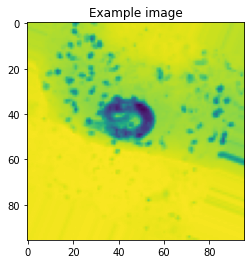

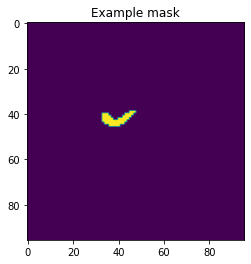

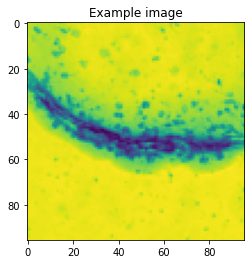

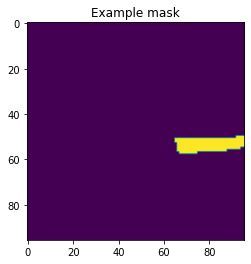

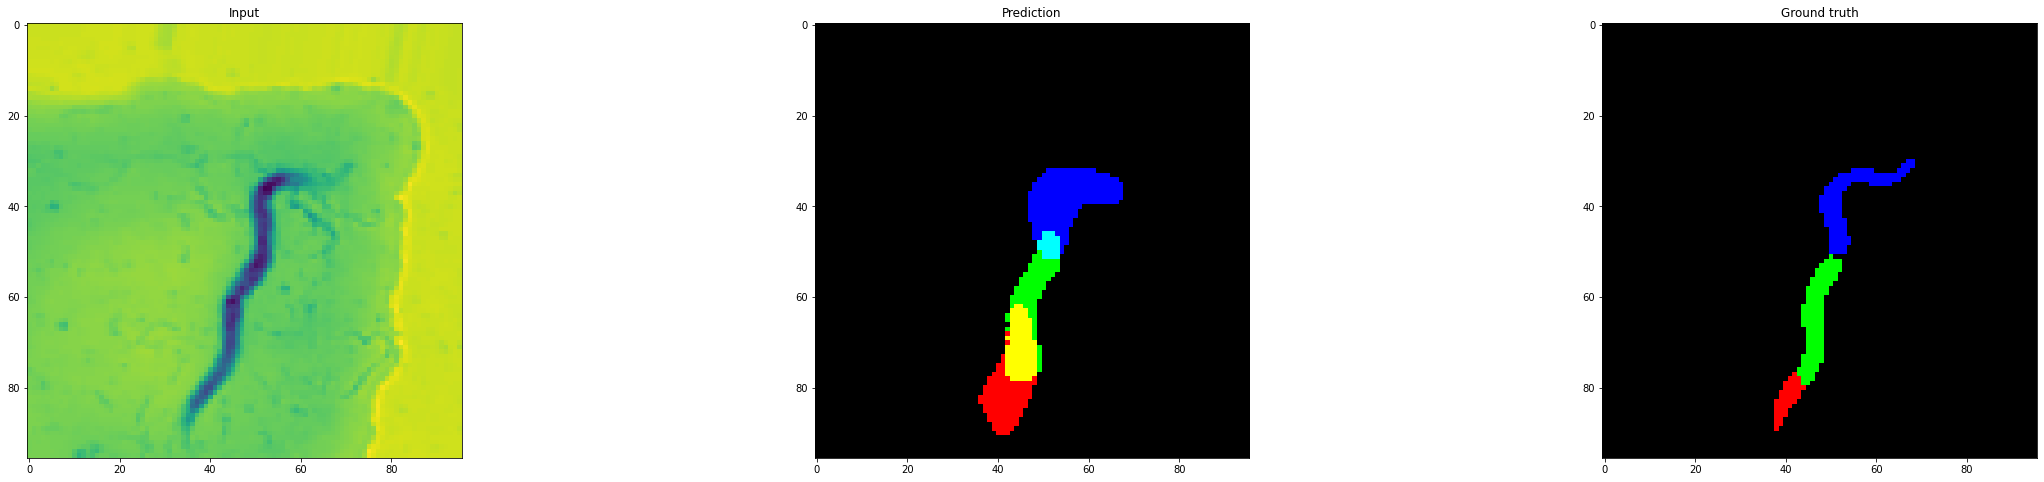

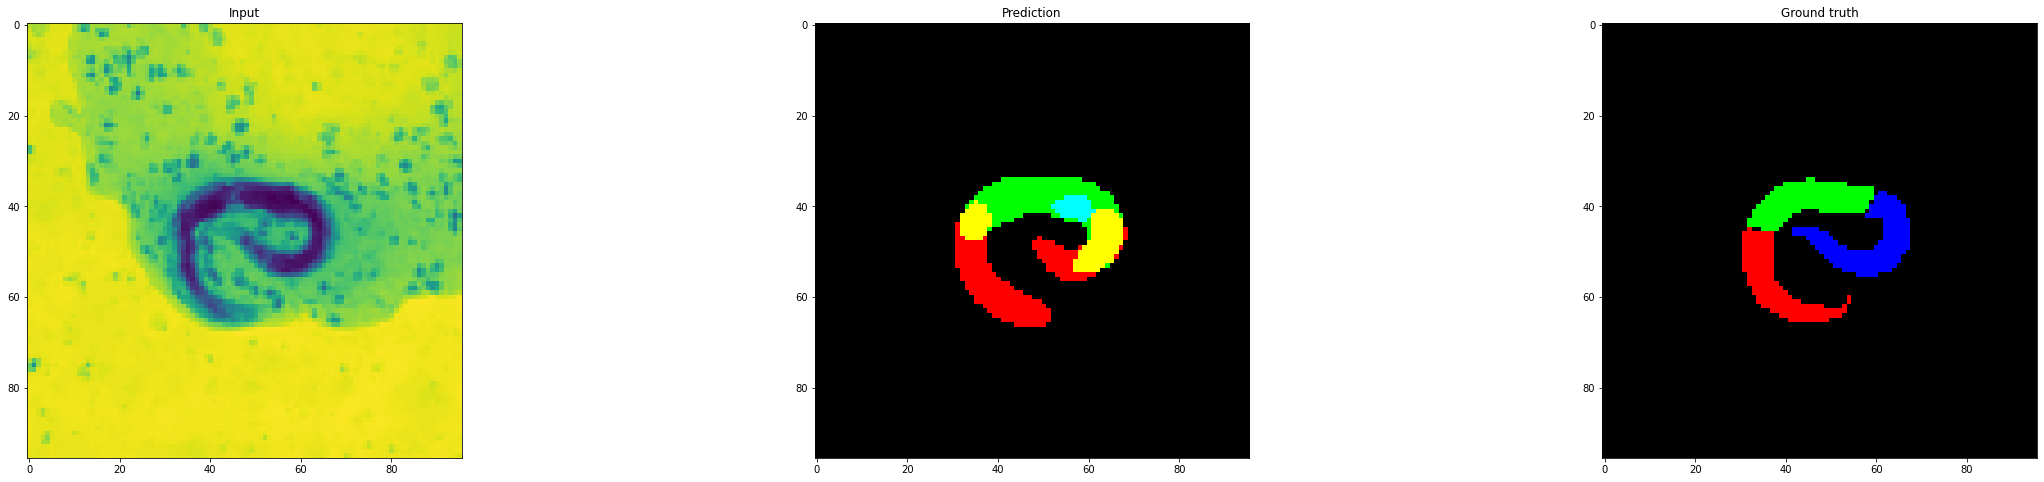

In [ ]:
upscale_factor_width = img_cols / target_width
upscale_factor_height = img_cols / target_height

runningTime = time.strftime('%b-%d-%Y_%H-%M')
model_dir = '/content/drive/My Drive/worm_models/fine-segmentation/models/final'

log_dir = os.path.join(model_dir,"{}_unet_multihead_fg_3head".format(runningTime))
checkDir(log_dir)

training_img_dir = os.path.join(model_dir,'..','..','train','img')
test_img_dir = os.path.join(model_dir,'..','..','test','img')

# load training images and masks
training_imgs = np.load(os.path.join(model_dir,'..','..','train','train_imgs_{}.npy'.format(target_height)))
training_masks = np.load(os.path.join(model_dir,'..','..','train','train_msks_{}.npy'.format(target_height)))
training_masks_0 = (1 - training_masks[:,:,:,0])[..., np.newaxis]
training_masks_1 = training_masks[:,:,:,1][..., np.newaxis]
training_masks_2 = training_masks[:,:,:,2][..., np.newaxis]
training_masks_3 = training_masks[:,:,:,3][..., np.newaxis]

# load test images and masks
test_imgs = np.load(os.path.join(model_dir,'..','..','test','test_imgs_{}.npy'.format(target_height)))
test_masks = np.load(os.path.join(model_dir,'..','..','test','test_msks_{}.npy'.format(target_height)))
#test_masks_0 = (1 - test_masks[:,:,:,0])[..., np.newaxis]
test_masks_1 = test_masks[:,:,:,1][..., np.newaxis]
test_masks_2 = test_masks[:,:,:,2][..., np.newaxis]
test_masks_3 = test_masks[:,:,:,3][..., np.newaxis]

image_datagen.fit(training_imgs, augment=True, seed=seed)
mask_datagen.fit(training_masks, augment=True, seed=seed)

test_image_datagen.fit(test_imgs, augment=False, seed=seed)
test_mask_datagen.fit(test_masks, augment=False, seed=seed)

image_generator = image_datagen.flow(training_imgs, batch_size=batch_size, seed=seed)
#mask_generator_0 = mask_datagen.flow(training_masks_0, batch_size=batch_size, seed=seed)
mask_generator_1 = mask_datagen.flow(training_masks_1, batch_size=batch_size, seed=seed)
mask_generator_2 = mask_datagen.flow(training_masks_2, batch_size=batch_size, seed=seed)
mask_generator_3 = mask_datagen.flow(training_masks_3, batch_size=batch_size, seed=seed)

test_image_generator = test_image_datagen.flow(test_imgs, batch_size=batch_size, seed=seed)
#test_mask_generator_0 = test_mask_datagen.flow(test_masks_0, batch_size=batch_size, seed=seed)
test_mask_generator_1 = test_mask_datagen.flow(test_masks_1, batch_size=batch_size, seed=seed)
test_mask_generator_2 = test_mask_datagen.flow(test_masks_2, batch_size=batch_size, seed=seed)
test_mask_generator_3 = test_mask_datagen.flow(test_masks_3, batch_size=batch_size, seed=seed)

#image_generator = image_datagen.flow_from_directory(training_img_dir, batch_size=batch_size, seed=seed, color_mode='grayscale', save_format='tif', class_mode=None, target_size=(target_width, target_height))
#mask_generator = mask_datagen.flow_from_directory(training_mask_dir, batch_size=batch_size, seed=seed, color_mode='grayscale', save_format='tif', class_mode=None, target_size=(target_width, target_height))

#gen1 = combine_generators(image_generator, mask_generator_0,mask_generator_1,mask_generator_2,mask_generator_3)
gen1 = combine_generators3(image_generator, mask_generator_1,mask_generator_2,mask_generator_3)
#gen1 = MergedGenerators(image_generator, mask_generator)

gen_test = combine_generators3(test_image_generator, test_mask_generator_1,test_mask_generator_2,test_mask_generator_3)


img_exmp = image_generator.next()
mask_exmp = mask_generator_1.next()
mask_exmp = np.append(mask_exmp, mask_generator_2.next(), axis = 3)
mask_exmp = np.append(mask_exmp, mask_generator_3.next(), axis = 3)

plt.figure()
plt.title('Example image')
plt.imshow(np.squeeze(img_exmp[0]))

plt.figure()
plt.title('Example mask')
plt.imshow(np.squeeze(mask_exmp[0,:,:,0]))

test_img_exmp = test_image_generator.next()
test_mask_exmp = test_mask_generator_1.next()
test_mask_exmp = np.append(test_mask_exmp, test_mask_generator_2.next(), axis = 3)
test_mask_exmp = np.append(test_mask_exmp, test_mask_generator_3.next(), axis = 3)

plt.figure()
plt.title('Example image')
plt.imshow(np.squeeze(test_img_exmp[0]))

test_imgs = test_imgs.astype('float32')
plt.figure()
plt.title('Example mask')
plt.imshow(np.squeeze(test_mask_exmp[0,:,:,0]))

test_masks = test_masks.astype('float32')
test_masks = np.rint(test_masks)

#===================
#
#  Training
#
#===================


tensorboard = TensorBoard(log_dir=log_dir)
callbacksList = [tensorboard]

model = Unet_multihead_3head(target_width, target_height)
model.compile(optimizer=Adam(lr=start_lr), loss=dice_loss, metrics=[dice_coeff, jaccard_distance, 'accuracy'])
model.summary()
print("start tesorboard, cmd: tensorboard --logdir=\""+os.path.join(log_dir,"{}".format(runningTime)+"\""))

model.fit(
        gen1,
        steps_per_epoch=100, #200, 40
        epochs=epochs,
        #workers=10,
        validation_freq = 1,
        #use_multiprocessing = True,
        validation_data=gen_test, validation_steps=1,
        callbacks=callbacksList)

img_exmp = image_generator.next()
mask_exmp = stack_masks3(mask_generator_1.next(), mask_generator_2.next(), mask_generator_3.next())


test_model_nobg(model, img_exmp, mask_exmp, log_dir)

test_img_exmp = test_image_generator.next()
test_mask_exmp = stack_masks3(test_mask_generator_1.next(), test_mask_generator_2.next(), test_mask_generator_3.next())

test_model_nobg(model, test_img_exmp, test_mask_exmp, log_dir)
model.save(os.path.join(log_dir,'model.h5'))


# Unet Multihead Binarry Classification Foreground

Model: "Unet_multihead"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        [(None, 96, 96, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_38 (Conv2D)              (None, 96, 96, 8)    80          image_input[0][0]                
__________________________________________________________________________________________________
batch_normalization_38 (BatchNo (None, 96, 96, 8)    32          conv2d_38[0][0]                  
__________________________________________________________________________________________________
activation_38 (Activation)      (None, 96, 96, 8)    0           batch_normalization_38[0][0]     
_____________________________________________________________________________________

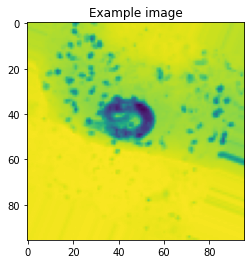

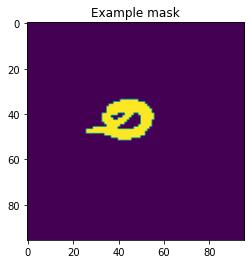

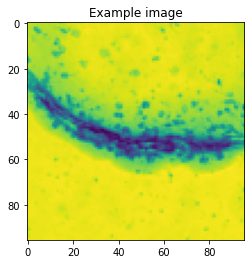

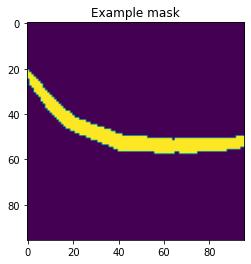

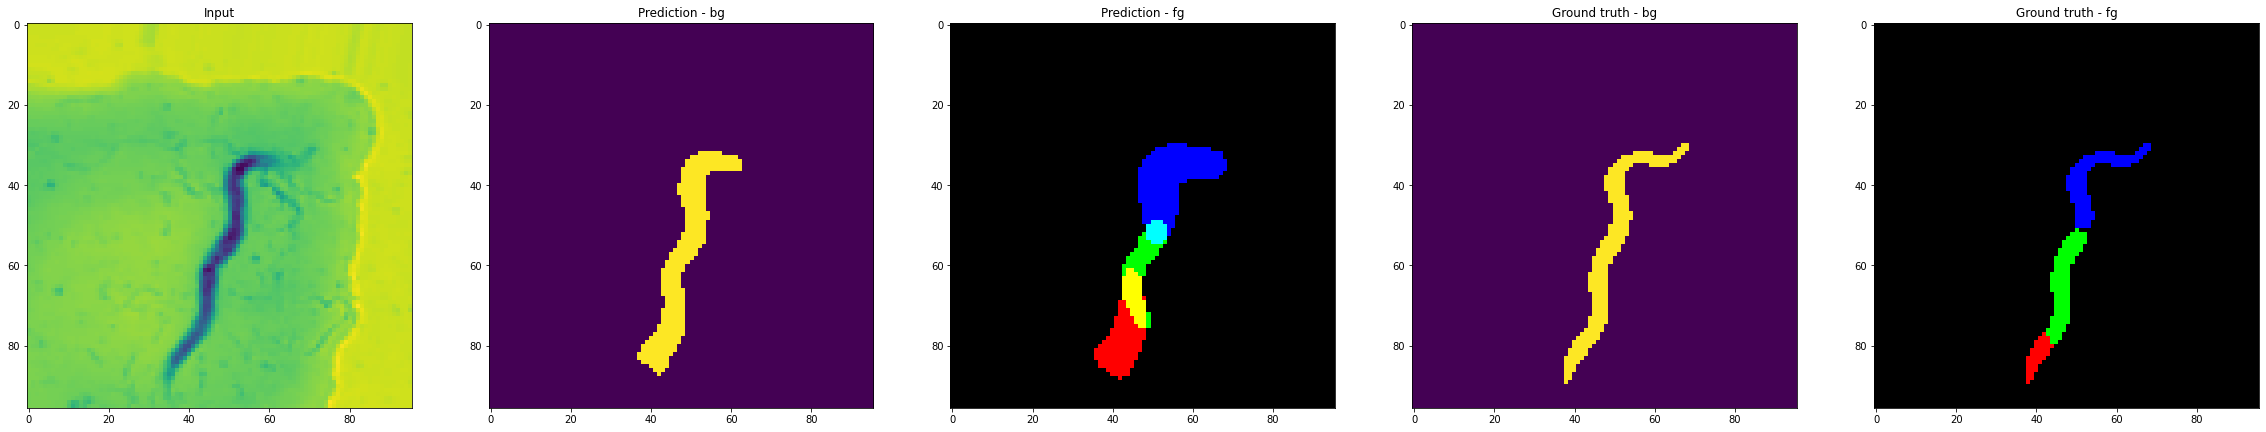

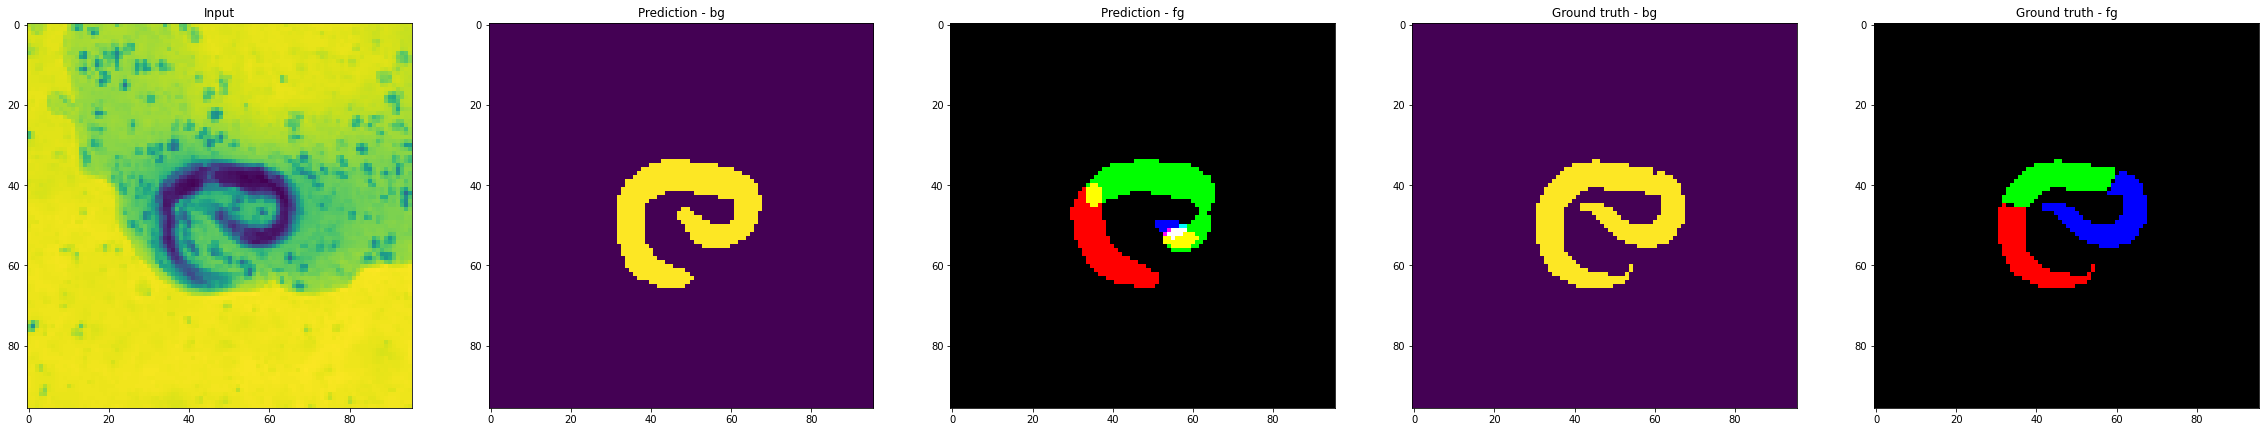

In [ ]:
upscale_factor_width = img_cols / target_width
upscale_factor_height = img_cols / target_height

runningTime = time.strftime('%b-%d-%Y_%H-%M')
model_dir = '/content/drive/My Drive/worm_models/fine-segmentation/models/final'

log_dir = os.path.join(model_dir,"{}_unet_multihead_fg".format(runningTime))
checkDir(log_dir)

training_img_dir = os.path.join(model_dir,'..','..','train','img')
test_img_dir = os.path.join(model_dir,'..','..','test','img')

# load training images and masks
training_imgs = np.load(os.path.join(model_dir,'..','..','train','train_imgs_{}.npy'.format(target_height)))
training_masks = np.load(os.path.join(model_dir,'..','..','train','train_msks_{}.npy'.format(target_height)))
training_masks_0 = (1 - training_masks[:,:,:,0])[..., np.newaxis]
training_masks_1 = training_masks[:,:,:,1][..., np.newaxis]
training_masks_2 = training_masks[:,:,:,2][..., np.newaxis]
training_masks_3 = training_masks[:,:,:,3][..., np.newaxis]

# load test images and masks
test_imgs = np.load(os.path.join(model_dir,'..','..','test','test_imgs_{}.npy'.format(target_height)))
test_masks = np.load(os.path.join(model_dir,'..','..','test','test_msks_{}.npy'.format(target_height)))
test_masks_0 = (1 - test_masks[:,:,:,0])[..., np.newaxis]
test_masks_1 = test_masks[:,:,:,1][..., np.newaxis]
test_masks_2 = test_masks[:,:,:,2][..., np.newaxis]
test_masks_3 = test_masks[:,:,:,3][..., np.newaxis]

image_datagen.fit(training_imgs, augment=True, seed=seed)
mask_datagen.fit(training_masks, augment=True, seed=seed)

test_image_datagen.fit(test_imgs, augment=False, seed=seed)
test_mask_datagen.fit(test_masks, augment=False, seed=seed)

image_generator = image_datagen.flow(training_imgs, batch_size=batch_size, seed=seed)
mask_generator_0 = mask_datagen.flow(training_masks_0, batch_size=batch_size, seed=seed)
mask_generator_1 = mask_datagen.flow(training_masks_1, batch_size=batch_size, seed=seed)
mask_generator_2 = mask_datagen.flow(training_masks_2, batch_size=batch_size, seed=seed)
mask_generator_3 = mask_datagen.flow(training_masks_3, batch_size=batch_size, seed=seed)

test_image_generator = test_image_datagen.flow(test_imgs, batch_size=batch_size, seed=seed)
test_mask_generator_0 = test_mask_datagen.flow(test_masks_0, batch_size=batch_size, seed=seed)
test_mask_generator_1 = test_mask_datagen.flow(test_masks_1, batch_size=batch_size, seed=seed)
test_mask_generator_2 = test_mask_datagen.flow(test_masks_2, batch_size=batch_size, seed=seed)
test_mask_generator_3 = test_mask_datagen.flow(test_masks_3, batch_size=batch_size, seed=seed)

#image_generator = image_datagen.flow_from_directory(training_img_dir, batch_size=batch_size, seed=seed, color_mode='grayscale', save_format='tif', class_mode=None, target_size=(target_width, target_height))
#mask_generator = mask_datagen.flow_from_directory(training_mask_dir, batch_size=batch_size, seed=seed, color_mode='grayscale', save_format='tif', class_mode=None, target_size=(target_width, target_height))

gen1 = combine_generators(image_generator, mask_generator_0,mask_generator_1,mask_generator_2,mask_generator_3)
#gen1 = MergedGenerators(image_generator, mask_generator)

gen_test = combine_generators(test_image_generator, test_mask_generator_0,test_mask_generator_1,test_mask_generator_2,test_mask_generator_3)


img_exmp = image_generator.next()
mask_exmp = mask_generator_0.next()
mask_exmp = np.append(mask_exmp, mask_generator_1.next(), axis = 3)
mask_exmp = np.append(mask_exmp, mask_generator_2.next(), axis = 3)
mask_exmp = np.append(mask_exmp, mask_generator_3.next(), axis = 3)

plt.figure()
plt.title('Example image')
plt.imshow(np.squeeze(img_exmp[0]))

plt.figure()
plt.title('Example mask')
plt.imshow(np.squeeze(mask_exmp[0,:,:,0]))

test_img_exmp = test_image_generator.next()
test_mask_exmp = test_mask_generator_0.next()
test_mask_exmp = np.append(test_mask_exmp, test_mask_generator_1.next(), axis = 3)
test_mask_exmp = np.append(test_mask_exmp, test_mask_generator_2.next(), axis = 3)
test_mask_exmp = np.append(test_mask_exmp, test_mask_generator_3.next(), axis = 3)

plt.figure()
plt.title('Example image')
plt.imshow(np.squeeze(test_img_exmp[0]))

test_imgs = test_imgs.astype('float32')
plt.figure()
plt.title('Example mask')
plt.imshow(np.squeeze(test_mask_exmp[0,:,:,0]))

test_masks = test_masks.astype('float32')
test_masks = np.rint(test_masks)

#===================
#
#  Training
#
#===================


tensorboard = TensorBoard(log_dir=log_dir)
callbacksList = [tensorboard]

model = Unet_multihead(target_width, target_height)
model.compile(optimizer=Adam(lr=start_lr), loss=dice_loss, metrics=[dice_coeff, jaccard_distance, 'accuracy'])
model.summary()
print("start tesorboard, cmd: tensorboard --logdir=\""+os.path.join(log_dir,"{}".format(runningTime)+"\""))

model.fit(
        gen1,
        steps_per_epoch=100, #200, 40
        epochs=epochs,
        #workers=10,
        validation_freq = 1,
        #use_multiprocessing = True,
        validation_data=gen_test, validation_steps=1,
        callbacks=callbacksList)

img_exmp = image_generator.next()
mask_exmp = stack_masks(mask_generator_0.next(), mask_generator_1.next(), mask_generator_2.next(), mask_generator_3.next())


test_model_bg(model, img_exmp, mask_exmp, log_dir)

test_img_exmp = test_image_generator.next()
test_mask_exmp = stack_masks(test_mask_generator_0.next(), test_mask_generator_1.next(), test_mask_generator_2.next(), test_mask_generator_3.next())

test_model_bg(model, test_img_exmp, test_mask_exmp, log_dir)
model.save(os.path.join(log_dir,'model.h5'))


**Unet Multihead Binarry Classification Background**

In [ ]:
upscale_factor_width = img_cols / target_width
upscale_factor_height = img_cols / target_height

runningTime = time.strftime('%b-%d-%Y_%H-%M')
model_dir = '/content/drive/My Drive/worm_models/fine-segmentation/models/final'

log_dir = os.path.join(model_dir,"{}_unet_multihead_bg".format(runningTime))
checkDir(log_dir)

training_img_dir = os.path.join(model_dir,'..','..','train','img')
test_img_dir = os.path.join(model_dir,'..','..','test','img')

# load training images and masks
training_imgs = np.load(os.path.join(model_dir,'..','..','train','train_imgs_{}.npy'.format(target_height)))
training_masks = np.load(os.path.join(model_dir,'..','..','train','train_msks_{}.npy'.format(target_height)))
training_masks_0 = training_masks[:,:,:,0][..., np.newaxis]
training_masks_1 = (1 - training_masks[:,:,:,1])[..., np.newaxis]
training_masks_2 = (1 - training_masks[:,:,:,2])[..., np.newaxis]
training_masks_3 = (1 - training_masks[:,:,:,3])[..., np.newaxis]

# load test images and masks
test_imgs = np.load(os.path.join(model_dir,'..','..','test','test_imgs_{}.npy'.format(target_height)))
test_masks = np.load(os.path.join(model_dir,'..','..','test','test_msks_{}.npy'.format(target_height)))
test_masks_0 = test_masks[:,:,:,0][..., np.newaxis]
test_masks_1 = (1 - test_masks[:,:,:,1])[..., np.newaxis]
test_masks_2 = (1 - test_masks[:,:,:,2])[..., np.newaxis]
test_masks_3 = (1 - test_masks[:,:,:,3])[..., np.newaxis]

image_datagen.fit(training_imgs, augment=True, seed=seed)
mask_datagen.fit(training_masks, augment=True, seed=seed)

test_image_datagen.fit(test_imgs, augment=False, seed=seed)
test_mask_datagen.fit(test_masks, augment=False, seed=seed)

image_generator = image_datagen.flow(training_imgs, batch_size=batch_size, seed=seed)
mask_generator_0 = mask_datagen.flow(training_masks_0, batch_size=batch_size, seed=seed)
mask_generator_1 = mask_datagen.flow(training_masks_1, batch_size=batch_size, seed=seed)
mask_generator_2 = mask_datagen.flow(training_masks_2, batch_size=batch_size, seed=seed)
mask_generator_3 = mask_datagen.flow(training_masks_3, batch_size=batch_size, seed=seed)

test_image_generator = test_image_datagen.flow(test_imgs, batch_size=batch_size, seed=seed)
test_mask_generator_0 = test_mask_datagen.flow(test_masks_0, batch_size=batch_size, seed=seed)
test_mask_generator_1 = test_mask_datagen.flow(test_masks_1, batch_size=batch_size, seed=seed)
test_mask_generator_2 = test_mask_datagen.flow(test_masks_2, batch_size=batch_size, seed=seed)
test_mask_generator_3 = test_mask_datagen.flow(test_masks_3, batch_size=batch_size, seed=seed)

#image_generator = image_datagen.flow_from_directory(training_img_dir, batch_size=batch_size, seed=seed, color_mode='grayscale', save_format='tif', class_mode=None, target_size=(target_width, target_height))
#mask_generator = mask_datagen.flow_from_directory(training_mask_dir, batch_size=batch_size, seed=seed, color_mode='grayscale', save_format='tif', class_mode=None, target_size=(target_width, target_height))

gen1 = combine_generators(image_generator, mask_generator_0,mask_generator_1,mask_generator_2,mask_generator_3)
#gen1 = MergedGenerators(image_generator, mask_generator)

gen_test = combine_generators(test_image_generator, test_mask_generator_0,test_mask_generator_1,test_mask_generator_2,test_mask_generator_3)


img_exmp = image_generator.next()
mask_exmp = mask_generator_0.next()
mask_exmp = np.append(mask_exmp, mask_generator_1.next(), axis = 3)
mask_exmp = np.append(mask_exmp, mask_generator_2.next(), axis = 3)
mask_exmp = np.append(mask_exmp, mask_generator_3.next(), axis = 3)

plt.figure()
plt.title('Example image')
plt.imshow(np.squeeze(img_exmp[0]))

plt.figure()
plt.title('Example mask')
plt.imshow(np.squeeze(mask_exmp[0,:,:,0]))

test_img_exmp = test_image_generator.next()
test_mask_exmp = test_mask_generator_0.next()
test_mask_exmp = np.append(test_mask_exmp, test_mask_generator_1.next(), axis = 3)
test_mask_exmp = np.append(test_mask_exmp, test_mask_generator_2.next(), axis = 3)
test_mask_exmp = np.append(test_mask_exmp, test_mask_generator_3.next(), axis = 3)

plt.figure()
plt.title('Example image')
plt.imshow(np.squeeze(test_img_exmp[0]))

test_imgs = test_imgs.astype('float32')
plt.figure()
plt.title('Example mask')
plt.imshow(np.squeeze(test_mask_exmp[0,:,:,0]))

test_masks = test_masks.astype('float32')
test_masks = np.rint(test_masks)

#===================
#
#  Training
#
#===================


tensorboard = TensorBoard(log_dir=log_dir)
callbacksList = [tensorboard]

model = Unet_multihead(target_width, target_height)
model.compile(optimizer=Adam(lr=start_lr), loss=dice_loss, metrics=[dice_coeff, jaccard_distance, 'accuracy'])
model.summary()
print("start tesorboard, cmd: tensorboard --logdir=\""+os.path.join(log_dir,"{}".format(runningTime)+"\""))

model.fit(
        gen1,
        steps_per_epoch=100, #200, 40
        epochs=epochs,
        #workers=10,
        validation_freq = 1,
        #use_multiprocessing = True,
        validation_data=gen_test, validation_steps=1,
        callbacks=callbacksList)

img_exmp = image_generator.next()
mask_exmp = stack_masks(mask_generator_0.next(), mask_generator_1.next(), mask_generator_2.next(), mask_generator_3.next())


test_model_bg(model, img_exmp, mask_exmp, log_dir)

test_img_exmp = test_image_generator.next()
test_mask_exmp = stack_masks(test_mask_generator_0.next(), test_mask_generator_1.next(), test_mask_generator_2.next(), test_mask_generator_3.next())

test_model_bg(model, test_img_exmp, test_mask_exmp, log_dir)
model.save(os.path.join(log_dir,'model.h5'))


In [ ]:
#test_model(model, test_image_generator.next(), test_mask_generator.next(), log_dir)

In [ ]:
#a = model.predict(image_generator.next())

In [ ]:
#b = mask_generator.next()[0,:,:,:]

In [ ]:
#c = a[0]

In [ ]:
#a.shape

In [ ]:
#b[:,:,0].max()

In [ ]:
#mask_generator.next()
#b = model.predict(image_generator.next())[0]

In [ ]:
#a = imread(os.path.join(training_mask_dir_head2,'2016-03-27t2101_bf_crop_y1256-x1100_12.png'), as_gray=True)
#plt.imshow(np.invert(a))

In [ ]:
#b = imread(os.path.join(training_mask_dir_head,'2983_2016-03-21t2317_bf_crop_y1027-x1138_00.png'), as_gray=True)
#plt.imshow(b)

In [ ]:
#plt.imshow(np.squeeze(b))

In [ ]:
#c[c<0.3] = 0
#c[c>0.3] = 1
#plt.imshow(np.squeeze(b))